<a href="https://colab.research.google.com/github/threegenie/knn_project/blob/main/new_work_times_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os, sys
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
# df1 = pd.read_csv('/content/drive/My Drive/df_2016.csv',encoding= 'unicode_escape')
# df2 = pd.read_csv('/content/drive/My Drive/df_2017.csv',encoding= 'unicode_escape')
# df3 = pd.read_csv('/content/drive/My Drive/df_2018.csv',encoding= 'unicode_escape')
# df4 = pd.read_csv('/content/drive/My Drive/df_2019.csv',encoding= 'unicode_escape')
df = pd.read_csv('/content/drive/My Drive/df_2020.csv',encoding= 'unicode_escape')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# df = pd.concat([df4,df5],ignore_index=True)
# df.shape

In [3]:
df.head()

,Unnamed: 0,year,sentence
0,0,2020,The fugitive from Japan has put Lebanon in an ...
1,1,2020,Mixed reaction to the news that Maj. Gen. Qass...
2,2,2020,"In bronze, silver or aluminum, a statue is an ..."
3,3,2020,"Also this week, holiday fireworks in Iceland a..."
4,4,2020,"The teenager, accused in the death of the Barn..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69119 entries, 0 to 69118
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  69119 non-null  int64 
 1   year        69119 non-null  int64 
 2   sentence    69119 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.6+ MB


In [5]:
df = df.drop(['Unnamed: 0','year'],axis=1)

In [6]:
df.head()

,sentence
0,The fugitive from Japan has put Lebanon in an ...
1,Mixed reaction to the news that Maj. Gen. Qass...
2,"In bronze, silver or aluminum, a statue is an ..."
3,"Also this week, holiday fireworks in Iceland a..."
4,"The teenager, accused in the death of the Barn..."


#### 토큰 정제

In [7]:
!pip install squarify

In [8]:
import re
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.tokenizer import Tokenizer

In [9]:
#기본 불용어 불러오기
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)
print(nlp.Defaults.stop_words)

{'whither', 'her', 'toward', 'so', 'fifteen', 'nowhere', 'also', 'upon', 'part', 'ever', 'eleven', 'is', 'each', 'while', 'into', 'nobody', 'thus', 'which', 'anyway', 'mine', 'take', 'nevertheless', 'empty', "'d", 'few', 'namely', 'three', 'became', '’ve', 'during', 'across', 'above', 'via', 'show', 'do', '‘ll', 'latter', 'might', '‘m', 'hence', 'see', 'without', 'after', 'give', 'and', 'between', 'down', 'never', 'same', 'third', 'well', 'should', 'much', 'thereupon', 'though', 'cannot', 'seems', 'say', '‘re', 'anyone', 'we', 'did', 'very', 'fifty', 'moreover', 'go', 'six', 'again', 'formerly', 'become', 'himself', 'beforehand', 'until', 'those', 'them', 'too', 'always', '‘s', 'she', 'everywhere', 'keep', 'be', 'through', 'were', 'here', 'to', 'call', 'whenever', 'whereas', 'even', 'last', 'most', 'as', '’d', 'one', '’ll', 'within', 'make', 'hereby', 'rather', 'all', 'what', 'myself', 'used', 'whose', 'already', 'how', 'against', 'serious', 'except', 'themselves', 'since', 'me', 'amon

In [10]:
#불용어 추가하기
st_words = nlp.Defaults.stop_words.union(['this', 'i', 'it', 'is', 'in', 'and', 'a', 'the', 'but', 'to', 'the',
                                          'â\x80\x94','said','york','u.s.','not','day','date','year','time'])

In [11]:
def tokenize(text):
  text = text.lower()
  text = text.replace("\n"," ")

  subst = ""
  regex = "[^a-zA-Z0-9 ]"
  doc = re.sub(regex, subst, text)

  doc = nlp(doc)
  tokens = []

  for token in doc :
    if (token.text.lower() not in st_words) & (token.is_stop == False) & (token.is_punct == False) & (token.is_alpha):
      tokens.append(token.lemma_)
      
  return tokens

In [12]:
df['Tokens']=df['sentence'].apply(tokenize)
df['Tokens'].head(3)

0    [fugitive, japan, lebanon, awkward, position, ...
1    [mixed, reaction, news, maj, gen, qassim, sule...
2    [bronze, silver, aluminum, statue, idea, solid...
Name: Tokens, dtype: object

#### 단어 빈도에 따라 시각화

In [13]:
def word_count(docs):
   
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [14]:
from collections import Counter
word_counts = Counter()
df['Tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(10)

[('new', 11379),
 ('coronavirus', 10197),
 ('trump', 8213),
 ('president', 6397),
 ('not', 4915),
 ('pandemic', 4898),
 ('state', 3393),
 ('people', 3359),
 ('need', 3254),
 ('election', 3244)]

In [15]:
wc = word_count(df['Tokens'])
wc.head(5)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
47,new,10062,11379,1.0,0.009915,0.009915,0.145575
5481,coronavirus,9573,10197,2.0,0.008885,0.018801,0.138500
490,trump,6685,8213,3.0,0.007157,0.025957,0.096717
817,president,5817,6397,4.0,0.005574,0.031532,0.084159
228,not,4594,4915,5.0,0.004283,0.035814,0.066465


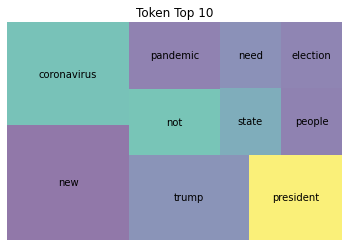

In [16]:
import squarify
import matplotlib.pyplot as plt

color=['viridis']

wc_top5 = wc[wc['rank'] <= 10]
squarify.plot(sizes=wc_top5['percent'], label=wc_top5['word'], alpha=0.6)
plt.axis('off')
plt.title('Token Top 10')
plt.show()

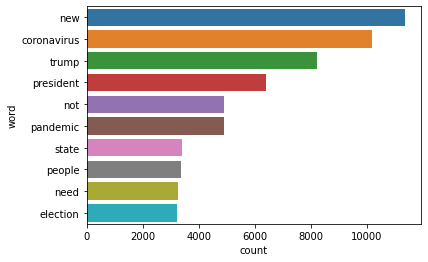

In [18]:
sns.barplot(y=wc['word'][:10],x=wc['count'][:10],orient='h')